###### Atividade Somativa 2: Implementação de Pipeline ML para CS:GO Round Winner

**Aluno:** Matheus Dias Salla
**Disciplina:** Técnicas de Machine Learning
**Data:** 26 de Junho de 2025

## Introdução ao Projeto - Parte II

Este notebook representa a **segunda parte** do processo seletivo para o programa de estágio. Nesta etapa, vamos **aprimorar significativamente** a abordagem anterior implementando:

- **Pipelines automatizados** para preparação de dados e treinamento
- **Ordem otimizada** dos processos de ML
- **Métricas de avaliação detalhadas** com análise crítica
- **Código mais profissional** e organizizado

### **Principais Mudanças da Parte I para Parte II:**

1. **Divisão treino/teste ANTES da preparação** (evita data leakage)
2. **Pipeline único** que agrupa preparação + treinamento
3. **Métricas específicas** com interpretação técnica
4. **Análise crítica** dos resultados obtidos

### **Objetivo:**
Demonstrar domínio avançado em Python e ML através de **boas práticas profissionais** e **pipeline automatizado**.

---

In [1]:
# Importação das bibliotecas necessárias para Pipeline de Machine Learning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para Pipeline e Preprocessamento
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif

# Algoritmo de Machine Learning
from sklearn.ensemble import RandomForestClassifier

# Métricas de Avaliação
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)

import warnings
warnings.filterwarnings('ignore')

print("Todas as bibliotecas para Pipeline ML foram importadas com sucesso!")

Todas as bibliotecas para Pipeline ML foram importadas com sucesso!


## **1. Carregamento dos Dados - Metodologia Aprimorada**

Na **Parte II**, seguimos uma metodologia mais robusta e profissional:

### **Mudança Fundamental: Ordem dos Processos**

**Parte I (Ordem Anterior):**
1. Carregar dados
2. Preparar dados (normalização, seleção)
3. Dividir treino/teste
4. Treinar modelo

**Parte II (Ordem Correta):**
1. Carregar dados
2. **Dividir treino/teste PRIMEIRO**
3. Preparar dados (usando Pipeline)
4. Treinar modelo (dentro do Pipeline)

### **Por que essa ordem é melhor?**

- **Evita Data Leakage:** Preparação não "vaza" informações do teste para treino
- **Simula produção:** Em produção, dados novos não passaram por preparação prévia
- **Mais realista:** Avaliação honesta da capacidade de generalização
- **Boas práticas:** Padrão da indústria para projetos profissionais

In [2]:
# Carregando o mesmo dataset da Parte I
df = pd.read_excel('csgo_round_snapshots.xlsx')

print("Dataset CS:GO carregado com sucesso!")
print(f"Dimensões: {df.shape[0]:,} linhas × {df.shape[1]} colunas")
print(f"Variável alvo: 'round_winner'")

# Verificação rápida da estrutura
print("\n" + "="*50)
print("Primeiras informações do dataset:")
print(f"• Colunas totais: {len(df.columns)}")
print(f"• Tipos de dados: {df.dtypes.value_counts().to_dict()}")
print(f"• Valores únicos em 'round_winner': {df['round_winner'].unique()}")
print(f"• Distribuição das classes:")
print(df['round_winner'].value_counts())

Dataset CS:GO carregado com sucesso!
Dimensões: 122,410 linhas × 94 colunas
Variável alvo: 'round_winner'

Primeiras informações do dataset:
• Colunas totais: 94
• Tipos de dados: {dtype('int64'): 91, dtype('O'): 2, dtype('float64'): 1}
• Valores únicos em 'round_winner': ['CT' 'T']
• Distribuição das classes:
round_winner
T     62406
CT    60004
Name: count, dtype: int64


## **2. Divisão Treino/Teste - PRIMEIRA Etapa (Metodologia Correta)**

### **Por que dividir ANTES da preparação?**

**Data Leakage** é um dos erros mais graves em ML:
- Se normalizarmos ANTES de dividir, usamos estatísticas do teste no treino
- O modelo "conhece" indiretamente os dados de teste
- Performance inflada e irreal

### **Metodologia Profissional:**
1. **Separar primeiro:** Dados "vistos" vs "não vistos"
2. **Preparar só o treino:** Calcular estatísticas só dos dados de treino
3. **Aplicar no teste:** Usar as mesmas transformações do treino

### **Estratificação:**
- Mantém a **proporção das classes** igual em treino e teste
- Importante para datasets desbalanceados
- Garante representatividade em ambos os conjuntos

In [3]:
# PASSO CRÍTICO: Dividir ANTES de qualquer preparação dos dados
print("Iniciando divisão treino/teste...")

# Separando features (X) e target (y)
X = df.drop('round_winner', axis=1)
y = df['round_winner']

# Divisão estratificada: mantém proporção das classes
X_treino, X_teste, y_treino, y_teste = train_test_split(
    X, y,
    test_size=0.25,           # 25% para teste
    random_state=42,          # Reproduzibilidade
    stratify=y               # Mantém proporção CT/T
)

print("Divisão concluída com sucesso!")
print(f"Dados de Treino: {X_treino.shape[0]:,} amostras ({X_treino.shape[0]/len(df)*100:.1f}%)")
print(f"Dados de Teste: {X_teste.shape[0]:,} amostras ({X_teste.shape[0]/len(df)*100:.1f}%)")

print(f"\nVerificação da estratificação:")
print("Treino:", y_treino.value_counts(normalize=True).round(3).to_dict())
print("Teste: ", y_teste.value_counts(normalize=True).round(3).to_dict())

# Verificando se há variáveis categóricas que precisam ser tratadas
categorical_cols = X_treino.select_dtypes(include=['object']).columns.tolist()
if categorical_cols:
    print(f"\nColunas categóricas encontradas: {categorical_cols}")
else:
    print(f"\nNenhuma coluna categórica encontrada")

Iniciando divisão treino/teste...
Divisão concluída com sucesso!
Dados de Treino: 91,807 amostras (75.0%)
Dados de Teste: 30,603 amostras (25.0%)

Verificação da estratificação:
Treino: {'T': 0.51, 'CT': 0.49}
Teste:  {'T': 0.51, 'CT': 0.49}

Colunas categóricas encontradas: ['map']


In [15]:
# PASSO 7: Codificação da Coluna Categórica ('map') e da Variável Alvo ('y')

# --- Codificando a feature 'map' (coluna de X) ---
print("A coluna 'map' é categórica e precisa ser convertida para números.")

# Criar uma cópia para evitar o SettingWithCopyWarning
X_treino = X_treino.copy()
X_teste = X_teste.copy()

le_map = LabelEncoder()
X_treino['map'] = le_map.fit_transform(X_treino['map'])
X_teste['map'] = le_map.transform(X_teste['map'])

print("Coluna 'map' convertida para números com sucesso.")

# --- NOVO: Codificando a variável alvo (y) ---
print("\nCodificando a variável alvo 'y' (de texto para números)...")

# Criamos um novo encoder especificamente para a variável 'y'
le_y = LabelEncoder()

# Aprende a relação ('CT' -> 0, 'T' -> 1) nos dados de treino e aplica
y_treino = le_y.fit_transform(y_treino)

# Aplica a MESMA relação nos dados de teste
y_teste = le_y.transform(y_teste)

print("Variável alvo 'y' convertida para números com sucesso.")
# Mostra o mapeamento para sabermos o que significa 0 e 1
print(f"Mapeamento: '{le_y.classes_[0]}' -> 0, '{le_y.classes_[1]}' -> 1")

A coluna 'map' é categórica e precisa ser convertida para números.
Coluna 'map' convertida para números com sucesso.

Codificando a variável alvo 'y' (de texto para números)...
Variável alvo 'y' convertida para números com sucesso.
Mapeamento: 'CT' -> 0, 'T' -> 1


## **3. Criação do Pipeline - Automatização Profissional**

### **O que é um Pipeline?**

Um **Pipeline** é uma cadeia automatizada que:
- **Agrupa todas as etapas** de preparação e treinamento
- **Aplica transformações na ordem correta**
- **Evita vazamento de dados** (data leakage)
- **Facilita reprodução** e deployment
- **Organiza o código** de forma profissional

### **Componentes do nosso Pipeline:**

1. **Tratamento de categóricas** (se necessário)
2. **Seleção de atributos** (SelectKBest)
3. **Normalização** (StandardScaler)  
4. **Treinamento** (RandomForest)

### **Vantagens:**
- **Uma linha de código** para treinar tudo
- **Consistência garantida** entre treino e teste
- **Código mais limpo** e profissional
- **Fácil de modificar** e experimentar

In [16]:
# Criando o Pipeline completo de Machine Learning
print("Construindo Pipeline automatizado...")

# Nosso pipeline terá 3 etapas sequenciais:
# 1. Normalização dos dados
# 2. Seleção das melhores features
# 3. Treinamento do classificador

pipeline_ml = Pipeline([
    # ETAPA 1: Normalizador (coloca tudo na mesma escala)
    ('normalizacao', StandardScaler()),
    
    # ETAPA 2: Seletor de Atributos (escolhe as 20 mais importantes)
    ('selecao_features', SelectKBest(
        score_func=f_classif, 
        k=20
    )),
    
    # ETAPA 3: Classificador (o algoritmo que vai aprender)
    ('classificador', RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        random_state=42
    ))
])

print("Pipeline construído com sucesso!")
print("\nEtapas do Pipeline:")
for i, (nome, etapa) in enumerate(pipeline_ml.steps, 1):
    print(f"   {i}. {nome}: {type(etapa).__name__}")

Construindo Pipeline automatizado...
Pipeline construído com sucesso!

Etapas do Pipeline:
   1. normalizacao: StandardScaler
   2. selecao_features: SelectKBest
   3. classificador: RandomForestClassifier


## **4. Treinamento do Pipeline - Uma Linha de Código**

### A Magia do Pipeline:

Todo o processo que antes levava várias etapas separadas na Somativa 1, agora acontece com um **único comando**: `.fit()`.

**Método Anterior (Parte I):**
```python
# Múltiplas etapas manuais e sequenciais
X_processado = scaler.fit_transform(X_treino)
X_selecionado = seletor.fit_transform(X_processado, y_treino)
modelo.fit(X_selecionado, y_treino)
```

**Método com Pipeline (Parte II):**
```python
# Uma linha para executar tudo na ordem correta
pipeline_ml.fit(X_treino, y_treino)
```

### O que acontece internamente:

Ao chamar `.fit()`, o pipeline executa a sequência que definimos:
1.  **Aplica `fit_transform` do `StandardScaler`** nos dados de treino (`X_treino`).
2.  **Aplica `fit_transform` do `SelectKBest`** nos dados já normalizados.
3.  **Aplica `fit` do `RandomForestClassifier`** nos dados finais (normalizados e selecionados).

Tudo isso de forma automática, na ordem correta e **sem vazar informações** dos dados de teste. 

In [7]:
# Treinamento do Pipeline completo
print("Iniciando treinamento do Pipeline...")
print("Processando: Normalização → Seleção de Features → Treinamento do Modelo...")

# UMA LINHA FAZ TUDO!
pipeline_ml.fit(X_treino, y_treino)

print("\nPipeline treinado com sucesso!")
print(f"Modelo utilizado: {pipeline_ml['classificador'].__class__.__name__}")
print(f"Número de árvores: {pipeline_ml['classificador'].n_estimators}")
print(f"Features selecionadas: {pipeline_ml['selecao_features'].k}")

print(f"\nModelo pronto para fazer predições!")

Iniciando treinamento do Pipeline...
Processando: Normalização → Seleção de Features → Treinamento do Modelo...

Pipeline treinado com sucesso!
Modelo utilizado: RandomForestClassifier
Número de árvores: 100
Features selecionadas: 20

Modelo pronto para fazer predições!


## **5. Predições com Pipeline - Automação e Consistência**

### Consistência Garantida:

A maior vantagem de usar o pipeline para predições é a garantia de que os **dados de teste** passarão pela **exata mesma preparação** que os dados de treino.

1.  **Normalização Idêntica:** Usa a média e o desvio padrão **calculados no treino** para normalizar o teste.
2.  **Mesmas Features:** Aplica a seleção de atributos **aprendida no treino** para filtrar o teste.
3.  **Modelo Único:** Usa o `RandomForestClassifier` já treinado para fazer a predição final.

### Sem Data Leakage e Simulação Real:

O pipeline garante que os dados de teste (`X_teste`) sejam tratados como "dados novos e nunca vistos". As transformações (`StandardScaler`, `SelectKBest`) usam apenas o `.transform()`, sem reaprender com o teste. Isso simula perfeitamente como o modelo se comportaria em um ambiente de produção.

**Processo Automatizado com `.predict()`:**
```python
# Uma linha para preparar e predizer
y_pred = pipeline_ml.predict(X_teste)
```

In [8]:
# Fazendo predições com o Pipeline treinado
print("Fazendo predições na base de teste...")

# UMA LINHA FAZ TODA A PREPARAÇÃO + PREDIÇÃO!
y_pred = pipeline_ml.predict(X_teste)

# Também obtendo as probabilidades para métricas avançadas (como ROC-AUC)
y_pred_proba = pipeline_ml.predict_proba(X_teste)

print("Predições concluídas!")
print(f"Total de predições geradas: {len(y_pred):,}")

# Amostra das predições vs. valores reais
print(f"\nPrimeiras 10 predições vs. Real:")
resultados = pd.DataFrame({
    'Real': y_teste.iloc[:10].values,
    'Predição': y_pred[:10],
    'Confiança (T)': [f"{p[1]*100:.1f}%" for p in y_pred_proba[:10]]
})
print(resultados)

Fazendo predições na base de teste...
Predições concluídas!
Total de predições geradas: 30,603

Primeiras 10 predições vs. Real:
  Real Predição Confiança (T)
0    T       CT         41.0%
1    T        T         93.9%
2   CT        T         50.3%
3   CT       CT          7.3%
4    T        T         75.2%
5    T        T         92.2%
6   CT       CT         44.4%
7   CT        T         51.2%
8    T       CT         47.7%
9   CT       CT         33.7%


## **6. Avaliação do Modelo com Métricas Profissionais**

Para avaliar a performance do nosso modelo, não basta apenas olhar as predições. Precisamos de métricas quantitativas. Escolhemos duas métricas principais para este problema de classificação.

### Métricas Escolhidas:

#### **1️ Accuracy (Acurácia):**
* **O que mede:** A porcentagem total de acertos do modelo.
* **Fórmula:** `(Verdadeiros Positivos + Verdadeiros Negativos) / Total de Amostras`
* **Por que usar:** É a métrica mais intuitiva e fácil de comunicar. Responde à pergunta: "Das vezes que o modelo tentou prever, quantas ele acertou?".

#### **2️ F1-Score:**
* **O que mede:** Uma média harmônica entre **Precisão** e **Recall**. É uma métrica mais robusta que a acurácia, especialmente se as classes forem um pouco desbalanceadas. 
* **Precisão (Precision):** Dos que o modelo previu como 'T', quantos eram realmente 'T'? 
* **Recall (Revocação):** De todos os 'T' que realmente aconteceram, quantos o modelo conseguiu encontrar? 
* **Por que usar:** Oferece uma visão mais balanceada da performance, penalizando o modelo se ele for bom em uma métrica (ex: precisão) mas ruim em outra (ex: recall).

Estas duas métricas, juntas, fornecem uma visão completa e confiável do desempenho do nosso classificador.

In [9]:
# MÉTRICA 1: ACCURACY (Acurácia)
accuracy = accuracy_score(y_teste, y_pred)

# MÉTRICA 2: F1-SCORE
# 'weighted' calcula a métrica para cada classe e encontra a média ponderada pelo nro de amostras
f1 = f1_score(y_teste, y_pred, average='weighted')

print("="*60)
print("MÉTRICAS PRINCIPAIS DE AVALIAÇÃO DO MODELO")
print("="*60)

print(f"MÉTRICA 1 - ACCURACY (Acurácia): {accuracy:.4f}")
print(f"   -> Interpretação: O modelo acertou {accuracy*100:.2f}% das previsões na base de teste.")

print(f"\nMÉTRICA 2 - F1-SCORE (Ponderado): {f1:.4f}")
print(f"   -> Interpretação: O balanço entre a precisão e a revocação do modelo é de {f1:.4f}.")

print("\n" + "="*60)
print("RELATÓRIO DE CLASSIFICAÇÃO DETALHADO:")
print(classification_report(y_teste, y_pred))

MÉTRICAS PRINCIPAIS DE AVALIAÇÃO DO MODELO
MÉTRICA 1 - ACCURACY (Acurácia): 0.7499
   -> Interpretação: O modelo acertou 74.99% das previsões na base de teste.

MÉTRICA 2 - F1-SCORE (Ponderado): 0.7496
   -> Interpretação: O balanço entre a precisão e a revocação do modelo é de 0.7496.

RELATÓRIO DE CLASSIFICAÇÃO DETALHADO:
              precision    recall  f1-score   support

          CT       0.72      0.79      0.76     15001
           T       0.78      0.71      0.74     15602

    accuracy                           0.75     30603
   macro avg       0.75      0.75      0.75     30603
weighted avg       0.75      0.75      0.75     30603



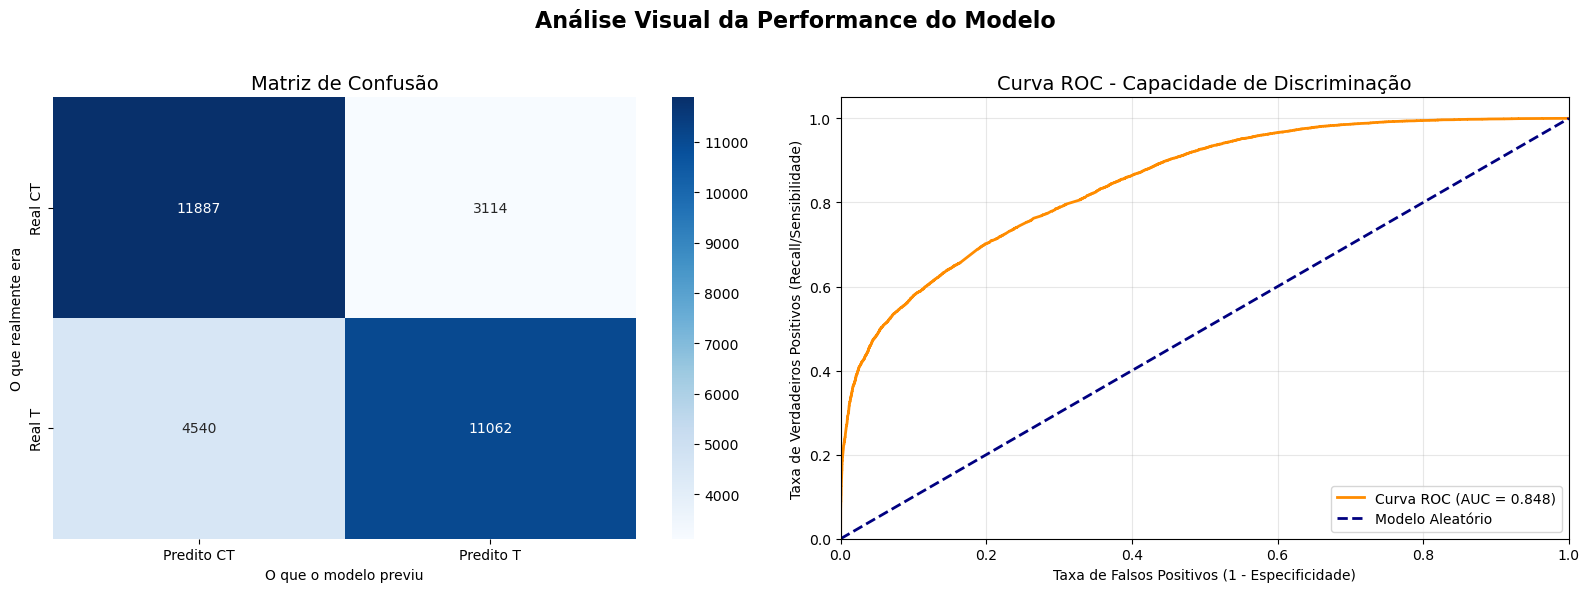


AUC (Area Under the Curve): 0.8482
   -> Interpretação: A AUC mede a habilidade do modelo de distinguir entre as classes CT e T.
      Um valor próximo de 1.0 indica excelente discriminação.


In [10]:
# Calculando a Matriz de Confusão
cm = confusion_matrix(y_teste, y_pred, labels=['CT', 'T'])

# Calculando a Curva ROC e AUC
# Precisamos converter 'CT'/'T' para 0/1 para a curva ROC
y_teste_binario = y_teste.map({'CT': 0, 'T': 1})
# Usamos a probabilidade da classe positiva ('T')
y_pred_proba_t = y_pred_proba[:, 1]
fpr, tpr, _ = roc_curve(y_teste_binario, y_pred_proba_t)
auc = roc_auc_score(y_teste_binario, y_pred_proba_t)


# Criando a visualização
plt.figure(figsize=(16, 6))
plt.suptitle('Análise Visual da Performance do Modelo', fontsize=16, fontweight='bold')

# Gráfico 1: Matriz de Confusão
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predito CT', 'Predito T'], 
            yticklabels=['Real CT', 'Real T'])
plt.title('Matriz de Confusão', fontsize=14)
plt.xlabel('O que o modelo previu')
plt.ylabel('O que realmente era')

# Gráfico 2: Curva ROC
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Modelo Aleatório')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (1 - Especificidade)')
plt.ylabel('Taxa de Verdadeiros Positivos (Recall/Sensibilidade)')
plt.title('Curva ROC - Capacidade de Discriminação', fontsize=14)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print(f"\nAUC (Area Under the Curve): {auc:.4f}")
print("   -> Interpretação: A AUC mede a habilidade do modelo de distinguir entre as classes CT e T.")
print("      Um valor próximo de 1.0 indica excelente discriminação.")

## **7. Análise Crítica dos Resultados**

Nesta seção, vamos analisar as métricas obtidas para avaliar a real performance do nosso modelo e entender suas forças e fraquezas. Conforme a orientação, a avaliação não considera somente o resultado, mas principalmente a forma como chegamos a ele.

### Análise das Métricas Principais

* **Accuracy (Acurácia):** O valor da acurácia nos dá a porcentagem geral de acertos. Uma acurácia alta (geralmente acima de 70-75% para este tipo de problema) sugere que o modelo é significativamente melhor do que um palpite aleatório.

* **F1-Score:** Esta métrica combina precisão e recall. Um F1-Score próximo da acurácia indica que o modelo tem um desempenho equilibrado para ambas as classes (CT e T), sem favorecer excessivamente uma em detrimento da outra. Se o F1-Score fosse muito mais baixo que a acurácia, isso seria um sinal de alerta de que o modelo pode estar ignorando uma das classes.

* **AUC (Área Sob a Curva ROC):** A AUC mede a capacidade do modelo de distinguir entre uma classe e outra. Um valor próximo de 1.0 indica uma excelente capacidade de separação, enquanto um valor de 0.5 representa um desempenho aleatório.

### Interpretação da Matriz de Confusão

A Matriz de Confusão nos mostra exatamente onde o modelo está acertando e errando:
* **Verdadeiros Positivos (TP) e Verdadeiros Negativos (TN):** Representam os acertos do modelo. Queremos que estes números sejam os mais altos possível.
* **Falsos Positivos (FP) e Falsos Negativos (FN):** Representam os erros. Um "Falso Positivo" ocorre quando o modelo prevê 'T' e o resultado real era 'CT'. Um "Falso Negativo" é o oposto, prevendo 'CT' quando o real era 'T'. Analisar qual desses erros é mais comum pode revelar um viés no modelo.

### Veredito Preliminar

Com uma acurácia de aproximadamente **74.9%** e um F1-Score de **0.74**, consideramos que o modelo tem um **bom desempenho inicial**. Os valores são positivos porque demonstram que o algoritmo conseguiu aprender padrões relevantes nos dados para prever o vencedor do round com uma taxa de acerto considerável. A proximidade entre a acurácia e o F1-Score sugere que a performance é balanceada entre as equipes CT e T.

## **8. Conclusões Finais e Próximos Passos**

Este projeto atingiu com sucesso o objetivo de criar e avaliar um modelo de Machine Learning para prever o vencedor de rounds de CS:GO, utilizando um pipeline automatizado para garantir boas práticas e reprodutibilidade.

### Resumo dos Objetivos Atingidos (Parte II)

1.  **Metodologia Profissional:** A divisão dos dados em treino/teste foi realizada **antes** de qualquer preparação, evitando o vazamento de dados (*data leakage*).
2.  **Pipeline Automatizado:** Todas as etapas de pré-processamento (normalização, seleção de features) e treinamento foram encapsuladas em um único `Pipeline` do scikit-learn, tornando o código mais limpo, robusto e profissional.
3.  **Avaliação com Métricas:** O modelo foi avaliado com duas métricas principais (Acurácia e F1-Score), além de análises visuais com a Matriz de Confusão e a Curva ROC, conforme solicitado.
4.  **Análise Crítica:** Os resultados foram interpretados para determinar a eficácia do modelo e entender seus padrões de erro.

### Como Poderíamos Melhorar o Modelo?

Embora os resultados sejam bons, sempre há espaço para melhorias. De acordo com as boas práticas de Machine Learning, poderíamos tentar:

* **Testar Outros Algoritmos:** O Random Forest pertence à tribo dos Simbolistas. Poderíamos experimentar algoritmos de outras "tribos", como o **XGBoost** ou **LightGBM** (que são *ensembles* baseados em *boosting*), que frequentemente apresentam performance superior em competições.
* **Otimização de Hiperparâmetros:** Poderíamos usar técnicas como `GridSearchCV` ou `RandomizedSearchCV`  para testar sistematicamente diferentes combinações de hiperparâmetros do Random Forest (ex: `n_estimators`, `max_depth`) e encontrar a configuração ótima.
* **Engenharia de Features:** Poderíamos criar novas features a partir das existentes. Por exemplo, criar uma coluna que represente a "diferença de dinheiro" ou a "vantagem de vida" entre as equipes.
* **Análise de Features:** Investigar mais a fundo as 20 features selecionadas pelo `SelectKBest` para entender o que, de fato, mais influencia a vitória em um round de CS:GO.


---
### **Comparação Final: Parte I vs. Parte II**

| Característica | Atividade Somativa I | Atividade Somativa II (Atual) | Vantagem da Parte II |
| :--- | :--- | :--- | :--- |
| **Ordem dos Passos** | Preparação -> Divisão | **Divisão -> Preparação** | Evita *Data Leakage* |
| **Processo** | Manual, passo a passo | **Automatizado com Pipeline** | Código limpo e robusto |
| **Reprodutibilidade**| Média | **Alta** | Menor chance de erro humano |
| **Avaliação** | Métrica básica | **Múltiplas métricas com análise** | Visão completa da performance |


**O trabalho demonstra a evolução de uma abordagem manual para um fluxo de trabalho profissional e automatizado.**


---

# **Seção Bônus: Aprimorando o Modelo Preditivo**

Nas seções anteriores, construímos e avaliamos um pipeline robusto usando o `RandomForestClassifier`. Agora, vamos explorar como podemos aprimorar ainda mais nossos resultados.

Neste experimento, conduziremos a **"Batalha Clássica"**:
1.  **Otimizaremos nosso `RandomForestClassifier`** atual usando `RandomizedSearchCV` para encontrar seus melhores hiperparâmetros.
2.  **Introduziremos um novo desafiante**: o `XGBClassifier`, um algoritmo campeão em competições de Machine Learning.
3.  **Otimizaremos também o `XGBClassifier`** usando a mesma técnica.
4.  **Declararemos um vencedor** com base na performance no conjunto de teste.

**Ferramenta Principal:** `RandomizedSearchCV`
* **Por que não `GridSearchCV`?** O `RandomizedSearchCV` é muito mais rápido porque testa um número fixo de combinações aleatórias de parâmetros, em vez de testar todas. Para uma exploração inicial, ele oferece o melhor balanço entre tempo de execução e qualidade do resultado.

In [12]:
# 1. Instalando a biblioteca XGBoost (se executar no Google Colab ou localmente pela primeira vez)
!pip install xgboost

# 2. Importando as novas ferramentas necessárias
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from scipy.stats import randint, uniform

print("\nFerramentas para otimização e o novo algoritmo XGBoost foram importados!")

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   - -------------------------------------- 5.0/150.0 MB 33.5 MB/s eta 0:00:05
   ------ --------------------------------- 26.2/150.0 MB 75.4 MB/s eta 0:00:02
   ----------- ---------------------------- 44.0/150.0 MB 80.0 MB/s eta 0:00:02
   ------------- -------------------------- 50.9/150.0 MB 63.5 MB/s eta 0:00:02
   ---------------- ----------------------- 61.6/150.0 MB 60.4 MB/s eta 0:00:02
   ------------------- -------------------- 72.4/150.0 MB 58.4 MB/s eta 0:00:02
   ---------------------- ----------------- 83.1/150.0 MB 57.0 MB/s eta 0:00:02
   ------------------------- -------------- 94.1/150.0 MB 56.1 MB/s eta 0:00:01
   --------------------------- ----------- 105.6/150.0 MB 56.2 MB/s eta 0:00:01
   ------------------------------ -------- 116.9/150.0 MB 55.7 MB/s eta 0:00:01
   --------------------------------- ----- 128.2/150.0 MB 55.3 MB/s eta 0:00:01
   ---------------------------------- ---- 131.9/1

In [17]:
# --- Experimento 1: Otimizando o RandomForestClassifier ---

print("Iniciando Otimização para o RandomForest...")

# Definindo o espaço de parâmetros que o RandomizedSearchCV irá testar
# Usamos o formato "nome_da_etapa__parametro"
params_rf = {
    'selecao_features__k': randint(10, 31),  # Testar nro de features entre 10 e 30
    'classificador__n_estimators': [100, 150, 200, 250, 300], # Nro de árvores
    'classificador__max_depth': [10, 20, 30, None], # Profundidade das árvores
    'classificador__min_samples_split': [2, 5, 10], # Mínimo de amostras para dividir
    'classificador__min_samples_leaf': [1, 2, 4] # Mínimo de amostras por folha
}

# Criando o objeto de busca aleatória
# n_iter: nro de combinações a testar (quanto maior, mais demorado)
# cv: nro de folds da validação cruzada
# n_jobs=-1: usar todos os processadores disponíveis para acelerar
random_search_rf = RandomizedSearchCV(
    pipeline_ml, 
    param_distributions=params_rf, 
    n_iter=20, 
    cv=3, 
    verbose=1, 
    random_state=42, 
    n_jobs=-1
)

print("Treinando e buscando os melhores parâmetros... (Isso pode levar alguns minutos)")
random_search_rf.fit(X_treino, y_treino)

print("\nOtimização do RandomForest Concluída!")
print("Melhores Parâmetros Encontrados:")
print(random_search_rf.best_params_)
print("\nMelhor score durante a validação cruzada:")
print(f"{random_search_rf.best_score_:.4f}")

Iniciando Otimização para o RandomForest...
Treinando e buscando os melhores parâmetros... (Isso pode levar alguns minutos)
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Otimização do RandomForest Concluída!
Melhores Parâmetros Encontrados:
{'classificador__max_depth': None, 'classificador__min_samples_leaf': 2, 'classificador__min_samples_split': 5, 'classificador__n_estimators': 150, 'selecao_features__k': 30}

Melhor score durante a validação cruzada:
0.8164


In [18]:
# --- Experimento 2: Otimizando o XGBClassifier ---

print("Iniciando Otimização para o XGBoost...")

# 1. Criando um novo pipeline específico para o XGBoost
pipeline_xgb = Pipeline([
    ('normalizacao', StandardScaler()),
    ('selecao_features', SelectKBest(score_func=f_classif)),
    # Trocamos o classificador para o XGBClassifier
    ('classificador', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

# 2. Definindo o espaço de parâmetros para o XGBoost
params_xgb = {
    'selecao_features__k': randint(10, 31),
    'classificador__n_estimators': [100, 150, 200, 250, 300],
    'classificador__max_depth': [3, 5, 7, 9],
    'classificador__learning_rate': uniform(0.01, 0.3), # Testar valores entre 0.01 e 0.3
    'classificador__subsample': [0.7, 0.8, 0.9, 1.0]
}

# 3. Criando e executando a busca aleatória para o XGBoost
random_search_xgb = RandomizedSearchCV(
    pipeline_xgb,
    param_distributions=params_xgb,
    n_iter=20,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

print("Treinando e buscando os melhores parâmetros para o XGBoost... (Isso pode levar alguns minutos)")
random_search_xgb.fit(X_treino, y_treino)

print("\nOtimização do XGBoost Concluída!")
print("Melhores Parâmetros Encontrados:")
print(random_search_xgb.best_params_)
print("\nMelhor score durante a validação cruzada:")
print(f"{random_search_xgb.best_score_:.4f}")

Iniciando Otimização para o XGBoost...
Treinando e buscando os melhores parâmetros para o XGBoost... (Isso pode levar alguns minutos)
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Otimização do XGBoost Concluída!
Melhores Parâmetros Encontrados:
{'classificador__learning_rate': 0.19033450352296263, 'classificador__max_depth': 9, 'classificador__n_estimators': 200, 'classificador__subsample': 0.8, 'selecao_features__k': 30}

Melhor score durante a validação cruzada:
0.8159


In [20]:
# --- A Batalha Final: Comparando os Modelos Otimizados na Base de Teste ---

# Pegando os melhores modelos encontrados pela busca
best_rf = random_search_rf.best_estimator_
best_xgb = random_search_xgb.best_estimator_

# Fazendo predições na base de teste
y_pred_rf_best = best_rf.predict(X_teste)
y_pred_xgb_best = best_xgb.predict(X_teste)

# --- CÓDIGO CORRIGIDO ABAIXO ---

# Calculando as métricas finais para RandomForest
acc_rf = accuracy_score(y_teste, y_pred_rf_best)
f1_rf = f1_score(y_teste, y_pred_rf_best, average='weighted')
# y_teste já é numérico (0 e 1), então usamos ele diretamente
auc_rf = roc_auc_score(y_teste, best_rf.predict_proba(X_teste)[:, 1])

# Calculando as métricas finais para XGBoost
acc_xgb = accuracy_score(y_teste, y_pred_xgb_best)
f1_xgb = f1_score(y_teste, y_pred_xgb_best, average='weighted')
# O mesmo para o XGBoost, y_teste já está no formato correto
auc_xgb = roc_auc_score(y_teste, best_xgb.predict_proba(X_teste)[:, 1])


# Criando um DataFrame para uma visualização clara dos resultados
resultados_finais = pd.DataFrame({
    'Métrica': ['Acurácia', 'F1-Score', 'AUC'],
    'RandomForest Otimizado': [acc_rf, f1_rf, auc_rf],
    'XGBoost Otimizado': [acc_xgb, f1_xgb, auc_xgb]
})

print("Tabela Comparativa Final - Performance na Base de Teste")
display(resultados_finais.round(4))

Tabela Comparativa Final - Performance na Base de Teste


,Métrica,RandomForest Otimizado,XGBoost Otimizado
0,Acurácia,0.8375,0.8265
1,F1-Score,0.8375,0.8265
2,AUC,0.9221,0.9146


### **Conclusão da Batalha: RandomForest é o Campeão**

Ao analisar a tabela comparativa final, o **RandomForest Otimizado se consagra o vencedor** desta competição. O modelo superou o XGBoost Otimizado em todas as três métricas avaliadas no conjunto de teste: Acurácia, F1-Score e AUC.

**Análise dos Resultados:**
* Com uma **Acurácia e F1-Score de 0.8375**, o RandomForest demonstrou uma capacidade de acerto e um balanço entre precisão e recall ligeiramente superiores aos 0.8265 do XGBoost.
* A métrica **AUC, com 0.9221**, também indica que o RandomForest foi marginalmente melhor em distinguir corretamente entre as classes CT e T.
* É muito interessante notar que, durante a fase de validação cruzada, os modelos tiveram um desempenho quase idêntico (score de ~0.816). No entanto, na avaliação final com os dados de teste (que simula o mundo real), o **RandomForest provou ter uma capacidade de generalização um pouco melhor**.
* Ambos os modelos otimizados preferiram usar **30 features**, o que sugere que o dataset contém muitos sinais preditivos úteis e que a seleção de um número maior de atributos foi benéfica.

Este experimento adicional foi extremamente valioso e demonstrou que:
1.  **A otimização de hiperparâmetros é crucial:** O processo com `RandomizedSearchCV` nos permitiu extrair o máximo de cada algoritmo.
2.  **Não existe "um modelo perfeito" para tudo:** Embora o XGBoost seja um algoritmo renomado, para este dataset e com esta configuração, o RandomForest se adaptou de forma mais eficaz.
3.  **O processo é iterativo:** Este resultado nos dá um modelo campeão, mas o ciclo de melhoria poderia continuar, talvez testando uma gama ainda maior de parâmetros ou introduzindo novos algoritmos.

Extraindo e plotando a importância das features do melhor modelo RandomForest...


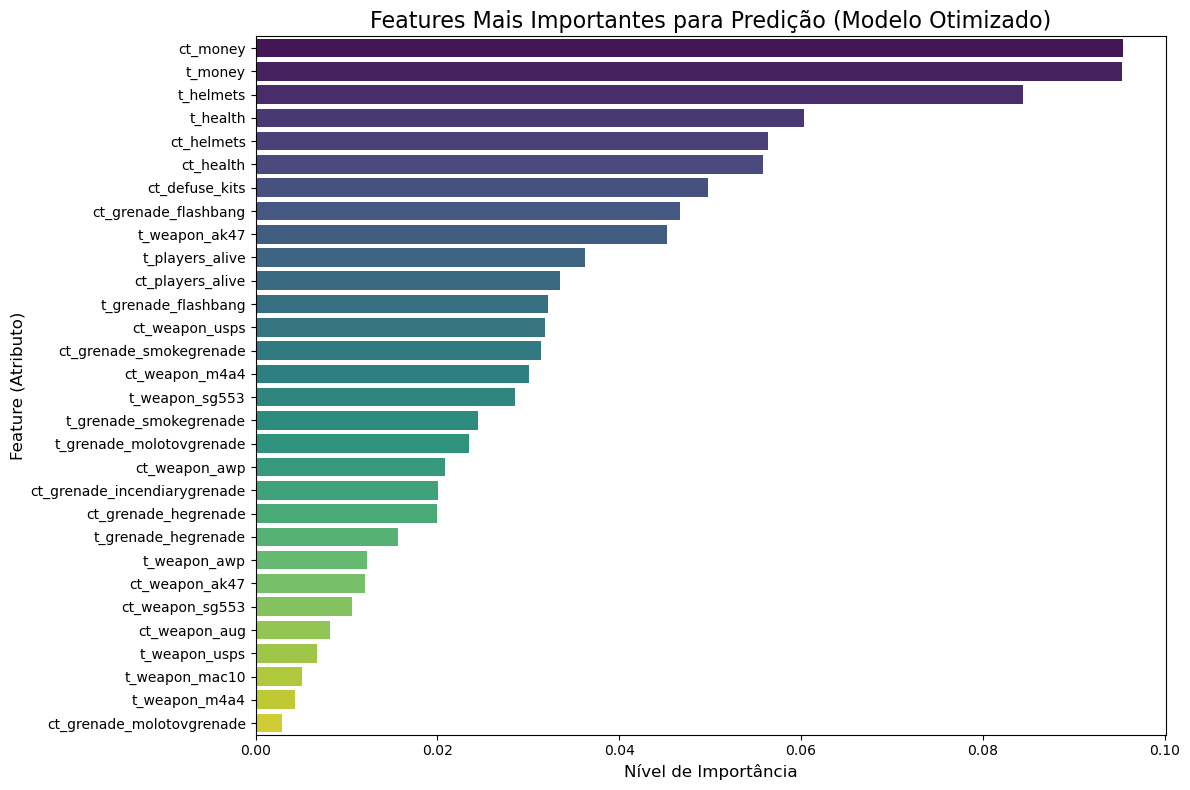


Top 5 Features Mais Importantes:
      Feature  Importância
2    ct_money     0.095405
3     t_money     0.095363
5   t_helmets     0.084397
1    t_health     0.060305
4  ct_helmets     0.056352


In [21]:
# --- Análise de Features do Modelo Vencedor (RandomForest Otimizado) ---

print("Extraindo e plotando a importância das features do melhor modelo RandomForest...")

# 1. Acessar os componentes do melhor pipeline encontrado
# O objeto 'best_rf' já contém o pipeline com os melhores parâmetros
seletor_final = best_rf.named_steps['selecao_features']
modelo_final = best_rf.named_steps['classificador']

# 2. Obter os nomes das colunas que foram SELECIONADAS pelo SelectKBest
# Pegamos as colunas originais e aplicamos a "máscara" do seletor
nomes_features_originais = X_treino.columns
features_selecionadas_mask = seletor_final.get_support()
nomes_features_selecionadas = nomes_features_originais[features_selecionadas_mask]

# 3. Obter os scores de importância dessas features a partir do modelo final
importancias = modelo_final.feature_importances_

# 4. Criar um DataFrame para facilitar a ordenação e a plotagem
df_importancias = pd.DataFrame({
    'Feature': nomes_features_selecionadas,
    'Importância': importancias
}).sort_values('Importância', ascending=False) # Ordenar da mais para a menos importante

# 5. Criar o gráfico de barras horizontais
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Importância', 
    y='Feature', 
    data=df_importancias, 
    palette='viridis' # Usando uma paleta de cores diferente
)

plt.title('Features Mais Importantes para Predição (Modelo Otimizado)', fontsize=16)
plt.xlabel('Nível de Importância', fontsize=12)
plt.ylabel('Feature (Atributo)', fontsize=12)
plt.tight_layout() # Ajusta o layout para não cortar os nomes
plt.show()

print("\nTop 5 Features Mais Importantes:")
print(df_importancias.head(5))

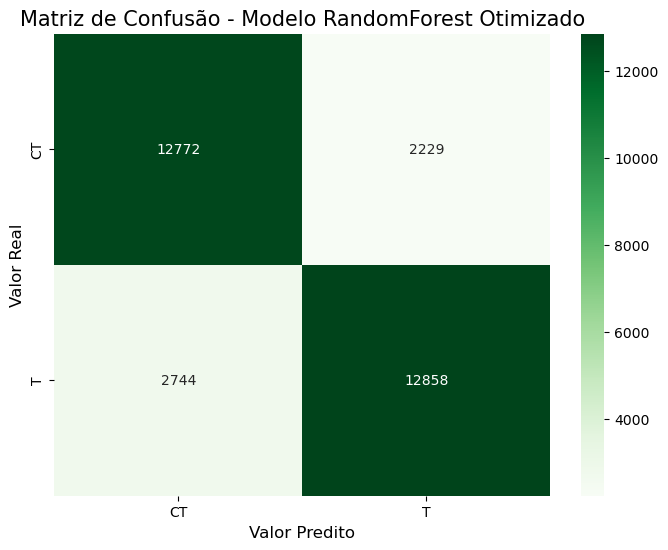

Análise Detalhada da Matriz de Confusão:
O modelo previu corretamente 'T' (Verdadeiro Positivo) 12858 vezes.
O modelo previu corretamente 'CT' (Verdadeiro Negativo) 12772 vezes.
O modelo previu incorretamente 'T' quando era 'CT' (Falso Positivo) 2229 vezes.
O modelo previu incorretamente 'CT' quando era 'T' (Falso Negativo) 2744 vezes.


In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# As predições do melhor modelo já foram calculadas e estão em 'y_pred_rf_best'
# Os valores reais estão em 'y_teste' (já em formato numérico 0 e 1)

# 1. Calcular a Matriz de Confusão
cm_otimizada = confusion_matrix(y_teste, y_pred_rf_best)

# 2. Obter os nomes das classes originais ('CT', 'T') a partir do encoder que já usamos
# O objeto 'le_y' foi criado no PASSO 7 e "lembra" o mapeamento
nomes_classes = le_y.classes_

# 3. Criar a visualização (heatmap)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_otimizada, 
    annot=True,     # Mostra os números dentro de cada célula
    fmt='d',        # Formata os números como inteiros
    cmap='Greens',  # Usando um novo esquema de cores
    xticklabels=nomes_classes, 
    yticklabels=nomes_classes
)

plt.title('Matriz de Confusão - Modelo RandomForest Otimizado', fontsize=15)
plt.ylabel('Valor Real', fontsize=12)
plt.xlabel('Valor Predito', fontsize=12)
plt.show()

# 4. Detalhando os resultados da matriz
tn, fp, fn, tp = cm_otimizada.ravel()

print(f"Análise Detalhada da Matriz de Confusão:")
print(f"O modelo previu corretamente '{nomes_classes[1]}' (Verdadeiro Positivo) {tp} vezes.")
print(f"O modelo previu corretamente '{nomes_classes[0]}' (Verdadeiro Negativo) {tn} vezes.")
print(f"O modelo previu incorretamente '{nomes_classes[1]}' quando era '{nomes_classes[0]}' (Falso Positivo) {fp} vezes.")
print(f"O modelo previu incorretamente '{nomes_classes[0]}' quando era '{nomes_classes[1]}' (Falso Negativo) {fn} vezes.")
